# 최근접 이웃(K-Nearest Neighbor)

* 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
* 분류와 회귀 모두 지원

![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

In [5]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

In [6]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.datasets import load_boston, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

## K 최근접 이웃 분류

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [72]:
iris = load_iris()

In [73]:
iris_df = pd.DataFrame(data = iris.data, columns = iris.feature_names)
iris_df['Target'] = iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [74]:
X, y = load_iris(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [75]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
# 이 부분  설명은 https://subinium.github.io/MLwithPython-3-3/ 참조
# 혹은 https://deepinsight.tistory.com/165 여기
# scaler.fit(X_train) -> scaler함수가 X_train 데이터를 학습함(고정된게 아님)
# 그 이후 transform이 실제로 데이터를 변환시킴. -> fit으로 train에 대해 학습하고, train과 test에 대해 같은 scaler로 transform 하는 게 올바른 변환 방식
# test도 test에 fit 해서 scaler 변환 후 transform 해버리는 건 잘못된 방법임.
# 이유는, test에서 fit해서 학습한 걸로 모델도 학습하는데, 새로 들어오는 데이터들도  기존 scaler로 해야한다는 가정이 있어야 surprise 데이터가 되어 기존 모델의 성능을 평가할 수 있음.
# 결국 최종적으로는 모든 데이터들이 같은 scaler로 스케일된 후 모델 적용해야하니까.. 모델 생성시의 scaler는 train으로부터 학습된 것이어야 함.

In [76]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [77]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.975
평가 데이터 점수: 0.9666666666666667


In [78]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier()

In [79]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.35833333333333334
평가 데이터 점수: 0.23333333333333334


In [80]:
cross_validate( # 교차검증 진행
    estimator = KNeighborsClassifier(),
    X=X, y=y,
    cv = 5, # k-fold 수 - 교차검증할때 데이터셋을 몇분할해서 할지
    n_jobs = multiprocessing.cpu_count(),
    verbose = True # 로그 출력
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.3s finished


{'fit_time': array([0.00199842, 0.00200033, 0.00100017, 0.00199747, 0.00199795]),
 'score_time': array([0.00599599, 0.00599504, 0.00399542, 0.00299811, 0.00399923]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [81]:
param_grid = [{'n_neighbors' : [3, 5, 7], # 이웃 수
              'weights' : ['uniform', 'distance'], # 가중치 방식은 uniform과 거리 방식 두개
               'algorithm' : ['ball_tree','kd_tree','brute'] # 여러 알고리듬들이 있음.
              }]
# parameter grid 생성

In [82]:
gs = GridSearchCV(
    estimator = KNeighborsClassifier(), # pipeline으로 scaler랑 model을 만들어서 pipe를 estimator로 넣어주면 정규화도 한번에 가능!
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [83]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=True)

In [84]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7)

In [85]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.9800000000000001


In [86]:
# 시각화를 위한 함수 정의
def make_meshgrid(x, y, h=0.02):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [94]:
tsne = TSNE(n_components = 2) # 다차원 벡터들을 2차원으로 차원축소
X_comp = tsne.fit_transform(X)

In [95]:
iris_comp_df = pd.DataFrame(X_comp)
iris_comp_df['Target'] = y
iris_comp_df

,0,1,Target
0,-9.359159,-25.382032,0
1,-10.244202,-22.816473,0
2,-9.080338,-22.699234,0
3,-9.450790,-22.315670,0
4,-9.745960,-25.510475,0
...,...,...,...
145,0.118028,7.942917,2
146,0.762345,11.117409,2
147,0.282394,8.838676,2
148,-0.560554,7.269244,2


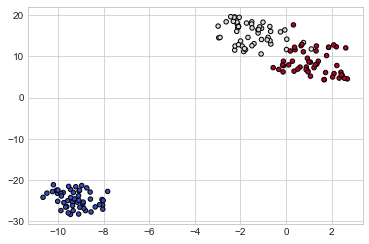

In [96]:
plt.scatter(X_comp[:,0], X_comp[:,1],
           c = y, cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k') # c는 색상값인데, y(target값. 0, 1, 2) 를 넣어 색상을 자동으로 구분하게 함.

In [33]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

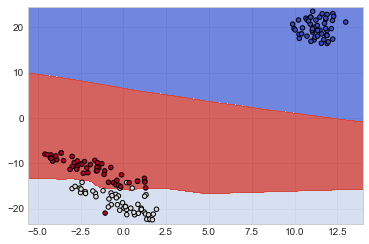

In [42]:
xx, yy = make_meshgrid(X_comp[:, 0], X_comp[:, 1])
plot_contours(model, xx, yy, cmap = plt.cm.coolwarm,  alpha = 0.8)
plt.scatter(X_comp[:, 0], X_comp[:, 1], c = y, cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')
# 실행시간 오래 걸리니까 주의!

### 유방암 데이터

## k 최근접 이웃 회귀

* k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터

In [97]:
boston = load_boston()

In [98]:
boston_df = pd.DataFrame(data = boston.data, columns = boston.feature_names)
boston_df['TARGET'] = boston.target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [99]:
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [100]:
boston_train_df = pd.DataFrame(data = X_train, columns = boston.feature_names)
boston_train_df['TARGET'] = y_train
boston_train_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,1.19294,0.0,21.89,0.0,0.624,6.326,97.7,2.2710,4.0,437.0,21.2,396.90,12.26,19.6
1,0.01778,95.0,1.47,0.0,0.403,7.135,13.9,7.6534,3.0,402.0,17.0,384.30,4.45,32.9
2,0.01360,75.0,4.00,0.0,0.410,5.888,47.6,7.3197,3.0,469.0,21.1,396.90,14.80,18.9
3,0.06417,0.0,5.96,0.0,0.499,5.933,68.2,3.3603,5.0,279.0,19.2,396.90,9.68,18.9
4,0.76162,20.0,3.97,0.0,0.647,5.560,62.8,1.9865,5.0,264.0,13.0,392.40,10.45,22.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,18.08460,0.0,18.10,0.0,0.679,6.434,100.0,1.8347,24.0,666.0,20.2,27.25,29.05,7.2
400,2.63548,0.0,9.90,0.0,0.544,4.973,37.8,2.5194,4.0,304.0,18.4,350.45,12.64,16.1
401,0.06047,0.0,2.46,0.0,0.488,6.153,68.8,3.2797,3.0,193.0,17.8,387.11,13.15,29.6
402,0.01501,90.0,1.21,1.0,0.401,7.923,24.8,5.8850,1.0,198.0,13.6,395.52,3.16,50.0


In [101]:
boston_test_df = pd.DataFrame(data = X_test, columns = boston.feature_names)
boston_test_df['TARGET'] = y_test
boston_test_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,12.04820,0.0,18.10,0.0,0.614,5.648,87.6,1.9512,24.0,666.0,20.2,291.55,14.10,20.8
1,5.87205,0.0,18.10,0.0,0.693,6.405,96.0,1.6768,24.0,666.0,20.2,396.90,19.37,12.5
2,0.25387,0.0,6.91,0.0,0.448,5.399,95.3,5.8700,3.0,233.0,17.9,396.90,30.81,14.4
3,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71,26.7
4,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.15936,0.0,6.91,0.0,0.448,6.211,6.5,5.7209,3.0,233.0,17.9,394.46,7.44,24.7
98,0.88125,0.0,21.89,0.0,0.624,5.637,94.7,1.9799,4.0,437.0,21.2,396.90,18.34,14.3
99,0.03551,25.0,4.86,0.0,0.426,6.167,46.7,5.4007,4.0,281.0,19.0,390.64,7.51,22.9
100,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


In [102]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [103]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [104]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.700089235881386
평가 데이터 점수: 0.4221320898500318


In [105]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [106]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.8703201719779906
평가 데이터 점수: 0.5458869387542657


In [107]:
estimator = make_pipeline( # cross_validate에서 estimator로 넣을 때는 요렇게 생성
    StandardScaler(),
    KNeighborsRegressor()
)

In [108]:
cross_validate(
    estimator = estimator, # pipeline 만든 거 집어넣음
    X = X, y = y,
    cv = 5,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.01398921, 0.01099181, 0.01998758, 0.01599026, 0.0099926 ]),
 'score_time': array([0.00999784, 0.00899696, 0.00999284, 0.00899339, 0.00899625]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

In [109]:
pipe = Pipeline( # GridSearchCV에 넣을때는 이렇게 파이프라인 생성해서 넣기
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())     
    ])

In [110]:
param_grid = [{'model__n_neighbors' : [3, 5, 7],
              'model__weights' : ['uniform', 'distance'],
              'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']}]

In [111]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs = multiprocessing.cpu_count(),
    verbose = True
)

In [112]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=4,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [113]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7,
                                     weights='distance'))])

In [114]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.4973060611762845


In [115]:
tsne = TSNE(n_components = 1) # regressor니까 클래스 구분이 없으니 1차원으로 축소해야함
X_comp = tsne.fit_transform(X)

In [116]:
boston_comp_df = pd.DataFrame(data = X_comp)
boston_comp_df['target'] = y
boston_comp_df

,0,target
0,-4.383225,24.0
1,11.666188,21.6
2,12.438999,34.7
3,13.889707,33.4
4,14.042924,36.2
...,...,...
501,-1.433066,22.4
502,-0.795689,20.6
503,0.000076,23.9
504,-0.045643,22.0


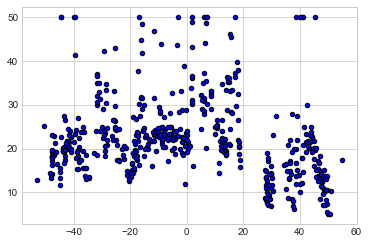

In [117]:
plt.scatter(X_comp, y, c = 'b', cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')

In [118]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

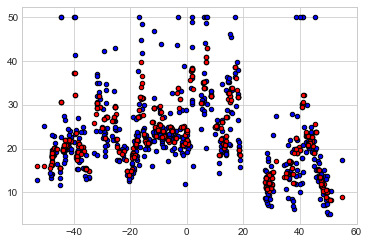

In [123]:
plt.scatter(X_comp, y, c = 'b', cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')
plt.scatter(X_comp, predict, c = 'r', cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')

### 캘리포니아 주택 가격 데이터